# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекc Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [214]:
# Импорт библиотек

import pandas as pd
import os.path, time
import datetime
from datetime import timedelta, datetime # для работы с датами
import numpy as np # для удобства вычислений
import matplotlib.pyplot as plt # импортируем библиотеку, стандартно используется имя plt

import seaborn as sns

try:
    df = pd.read_csv('C:/Users/datasets/real_estate_data.csv', sep='\t')
except:
    df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')  # Серверный путь
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.00,108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,NaN
1,7,3350000.00,40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,...,11.00,2.00,посёлок Шушары,12817.00,18603.00,0.00,NaN,0.00,NaN,81.00
2,10,5196000.00,56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,...,8.30,0.00,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558.00
3,0,64900000.00,159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,...,NaN,0.00,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424.00
4,2,10000000.00,100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121.00


### Вывод

Всего в датафрейме 23699 строк, видно, что в некоторых столбцах значения пропущены. Изначально все данные были склеены в одну строку, разделение было через "\t", что мы и указали в в качестве разделителя при чтении файла.
Также заметила, что в некоторых столбцах требуется корректировка типа данных: например, значение в столбце аппартаменты лучше выбрать логический тип данных(да/нет), first_day_exposition (дата публикации) - тип date, days_exposition(время размещения в днях) - целый тип integer, parks_around3000(парки поблизости) -  тоже лучше выбрать целый тип данных и пр.


Очень много пропусков, нужно разобраться в связи с чем такое количество.


## Предобработка данных

Для начала определим пропущенные значения.

In [215]:
df.isnull().sum()


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

<p><span style="color:#2F4F4F"><em>ceiling_height &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 9195 - высота потолков скорее всего не указана из-за отсутствия точных данных у владельца<br />
living_area &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;1903 - отсутствие данных&nbsp;<br />
floors_total &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 86&nbsp;<br />
is_apartment &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;20924<br />
kitchen_area &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 2278 - либо кухни нет, если это студия, либо нет точных данных<br />
balcony &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 11519 - часто люди путают значение лоджия и балкон, например, поэтому просто могли пропустить этот пункт, либо балконов просто нет<br />
locality_name &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;49<br />
airports_nearest &nbsp; &nbsp; &nbsp; &nbsp; 5542<br />
cityCenters_nearest &nbsp; &nbsp; &nbsp;5519<br />
parks_around3000 &nbsp; &nbsp; &nbsp; &nbsp; 5518<br />
parks_nearest &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 15620 - скорее всего не указана из-за отсутствия точных данных у владельца или отсутствия парков<br />
ponds_around3000 &nbsp; &nbsp; &nbsp; &nbsp; 5518<br />
ponds_nearest &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 14589<br />
days_exposition &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;3181 - вот это странные пропуски, т.к. в данных first_day_exposition - пропусков нет, непонятно откуда могли взять пропусти в столбце с количеством дней публикации</em></span></p>


In [216]:
# сначала перименуем столбец, чтобы было в едином регистре
df.rename(columns = {'cityCenters_nearest':'citycenters_nearest'}, inplace=True)

# меньше всего пропусков во floors_total и locality_name - можно их удалить, они не повлиют на статистику
df.dropna(subset=['locality_name', 'floors_total'], inplace=True)

In [217]:
# очень много пропусков в столбце is_apartment, 
# вероятно из-за того, что пользователи отмечали этот пункт  только в случае, если это аппартаменты
df['is_apartment'].value_counts() 

False    2710
True       50
Name: is_apartment, dtype: int64

In [218]:
# заменим пропуски на False
df['is_apartment'] = df['is_apartment'].fillna(value=False)

In [219]:
# Если это студия, то пропуски в записях с площадью кухни заменим на 0
df.loc[(df['studio'] == True) & (df['kitchen_area'] == None), 'kitchen_area'] == 0
df['kitchen_area'] = df['kitchen_area'].fillna(value=0).astype(float)


In [220]:
# проверим какие значения есть в названии населенных пунктов, выведем первые 50 строк сверху
df['locality_name'].value_counts().to_frame().head(50)

,locality_name
Санкт-Петербург,15651
посёлок Мурино,520
посёлок Шушары,439
Всеволожск,398
Пушкин,369
Колпино,338
посёлок Парголово,327
Гатчина,307
деревня Кудрово,299
Выборг,237


(!) Как можно заметить на первый взгляд - достаточно много дублирующих значений. Устраним их.

In [221]:
# заменим поселок на посёлок, чтобы убрать дубликаты по этой причине
df['locality_name'] = df['locality_name'].str.replace("посёлок", "поселок") 
# создаем функцию для исключения дубликатов в населенных пунктах
def replace_wrong_name(correct_name): # на вход функции подаются список неправильных значений и строка с правильным значением
    name = correct_name['locality_name']
    if 'удрово' in name:
        return 'Кудрово'
    elif 'урино' in name:
        return 'Мурино'
    elif 'Янино-1' in name:
        return 'городской поселок Янино-1'
    elif 'Старая Деревня' in name:
        return 'деревня Старая'
    return name
df['locality_name'] = df.apply(replace_wrong_name, axis = 1)
df['locality_name'].value_counts().to_frame().head(30)

,locality_name
Санкт-Петербург,15651
Мурино,586
Кудрово,470
поселок Шушары,439
Всеволожск,398
Пушкин,369
Колпино,338
поселок Парголово,327
Гатчина,307
Выборг,237


Теперь изменим тип данных, где это требуется

In [222]:


# поменяем формат даты
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%d')

# изменим на целый тип данных, и в столбцах с пропусками заменим значения на 0
df['last_price'] = df['last_price'].astype(int)
df['balcony'] = df['balcony'].fillna(value=0).astype(int)
df['parks_around3000'] = df['parks_around3000'].fillna(value=0).astype(int)
df['ponds_around3000'] = df['ponds_around3000'].fillna(value=0).astype(int)
# изменим на булевый тип данных
df['is_apartment'] = df['is_apartment'].astype('bool')



In [223]:
# df['rooms'].value_counts()
# проверили значения с количеством комнат
# есть 194 записи с количеством комнат 0 - скорее всего это студии или случайные пропуски
# логично будет заменить на инимальное количество комнат на 1

df.loc[(df['rooms'] == 0)] = 1
df['rooms'].value_counts()

1     8198
2     7897
3     5779
4     1172
5      325
6      104
7       59
8       12
9        8
10       3
11       2
14       2
16       1
19       1
12       1
15       1
Name: rooms, dtype: int64

In [224]:
# заменим пропущенные значения высоты потолков на медианные
df['ceiling_height'].fillna(df['ceiling_height'].median(), inplace=True)
# df.isnull().sum()

In [225]:
# Заполним пропуски до ближайших объектов(аэропорты, парки, водоемы) по средним значениям в зависимости от населенного пункта

# сгруппируем по населенным пунктам:
grouped_airpots_nearest = df.groupby('locality_name')['airports_nearest'].mean()
grouped_citycentres_nearest = df.groupby('locality_name')['citycenters_nearest'].mean()
grouped_parks_nearest = df.groupby('locality_name')['parks_nearest'].mean()
grouped_ponds_nearest = df.groupby('locality_name')['ponds_nearest'].mean()
df['airports_nearest'].fillna(grouped_airpots_nearest,inplace=True)
df['citycenters_nearest'].fillna(grouped_citycentres_nearest,inplace=True)
df['parks_nearest'].fillna(grouped_parks_nearest,inplace=True)
df['ponds_nearest'].fillna(grouped_ponds_nearest,inplace=True)

# Еще проверила версию - заменить расстояние на 0, если в значении водоемы(или парки) стоит 0. Но таких пропусков не было.
# df.loc[(df['ponds_around3000'] == 0) & (df['ponds_nearest']== None), 'parks_nearest'] == 0

# Оставшиеся пропуски связаны скорее всего с отсутствием объектов поблизости, 
# например, аэропорты обычно только в крупных населенных пунктах, а водоемы/парки наоборот чаще отсутствуют.
# Думаю дальше оставшиеся пропуски нужно просто оставить, потому что логически правильных значений уже не подобрать.

df.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1854
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5447
citycenters_nearest      5424
parks_around3000            0
parks_nearest           15368
ponds_around3000            0
ponds_nearest           14402
days_exposition          3157
dtype: int64

(!)Теперь хотелось бы разобраться с пропусками в столбце с количетсвом дней публикации days_exposition.
Для этого я нашла с помощью дату создания и последнего изменения файла. 
Потом вычту из нее дату первого размещения и получу количество дней публикации на время выгрузки датафрейма и заполню пропуски.

In [226]:
# import os.path, time  - импорт библиотек перенесла в начало работы для удобства
print("last modified: %s" % time.ctime(os.path.getmtime('/datasets/real_estate_data.csv')))
print("created: %s" % time.ctime(os.path.getctime('/datasets/real_estate_data.csv')))

last modified: Thu Mar 19 12:41:41 2020
created: Thu Mar 19 12:41:41 2020


In [227]:
# import datetime - импорт библиотеки перенесла наверх для удобства
import datetime 
from datetime import timedelta, datetime
# df.query('first_day_exposition != 1')
df = df[df.days_exposition != 1]
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%d')
                                        
# date_file = datetime(2020, 3, 19)
# df['days_exposition'] = df['days_exposition'].fillna((date_file - df['first_day_exposition']).dt.days)


# создала датафрейм для исследования с пропусками в днях - сроке публикации
df_day_nan = df[df['days_exposition'].isna()]
# Оставила только даты первых публикаций из предыдущего фильтра

df_day_nan = df_day_nan['first_day_exposition']

# df_day_nan.value_counts().sort_values().tail(50)


Пришлось отказаться от идеи заполнять пропуски, так как после анализа я увидела, что в основном большое количество пропусков было в 2019 и значительно меньше в 2018 - скорее всего это те объекты, которые еще не продались. 
Поэтому эти пропуски оставляем как есть, чтобы не мешать статистике.

In [229]:
# Заполним пропуски жилой площади, найдем среднее соотношение общей площади к жилой
living_total =  df['living_area'].median() / df['total_area'].median()
df['living_area'].fillna(living_total * df['total_area'], inplace=True)
# df['living_area'] = pd.to_numeric(df['living_area'], downcast='float16')
# df['living_area'] = np.array(df['living_area'],dtype='float16')

df.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5447
citycenters_nearest      5424
parks_around3000            0
parks_nearest           15368
ponds_around3000            0
ponds_nearest           14402
days_exposition          3157
dtype: int64

## Расчёты и добавление результатов в таблицу

<p>Посчитаем и добавим в таблицу:</p>

<ul>
	<li>
	<p>цену квадратного метра;</p>
	</li>
	<li>
	<p>день недели, месяц и год публикации объявления;</p>
	</li>
	<li>
	<p>этаж квартиры; варианты &mdash; первый, последний, другой;</p>
	</li>
	<li>
	<p>соотношение жилой и общей площади, а также отношение площади кухни к общей</p>
	</li>
</ul>


In [230]:
# Добавляем столбец с ценой квадратного метра и приводим его в целочисленный тип
df['m_price'] = df['last_price'] / df['total_area']
df['m_price'] = df['m_price'].astype(int)

# Добавляем столбцы дня недели, месяца и год публикации
df['weekday'] = df['first_day_exposition'].dt.weekday
df['month'] = df['first_day_exposition'].dt.month
df['year'] = df['first_day_exposition'].dt.year

# Функция для категорииэтажей
def floor_category(row):
    floor=row['floor']
    total_floor=row['floors_total']
    if floor==1:
        return 'Первый'
    if floor==total_floor:
        return 'Последний'
    return 'Другой'

# Добавляем столбец с вариантами этажей с использованием функции выше
df['floor_category'] = df.apply(floor_category,axis=1) 

# Добавляем столбец с отношением жилой площади к общей
df['living_to_total'] = df['living_area'] / df['total_area']
df['living_to_total'] = df['living_to_total'].fillna(value=0)
# pd.to_numeric(df['living_to_total'], downcast='float16')

# Добавляем столбец с отношением площади кухни к общей
df['kitchen_to_total'] = df['kitchen_area'] / df['total_area']
df['kitchen_to_total'] = df['kitchen_to_total'].fillna(value=0)

df

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,m_price,weekday,month,year,floor_category,living_to_total,kitchen_to_total
0,20,13000000,108.00,2019-03-07,3,2.70,16.00,51.00,8,False,...,2,755.00,NaN,120370,3,3,2019,Другой,0.47,0.23
1,7,3350000,40.40,2018-12-04,1,2.65,11.00,18.60,1,False,...,0,1.00,81.00,82920,1,12,2018,Первый,0.46,0.27
2,10,5196000,56.00,2015-08-20,2,2.65,5.00,34.30,4,False,...,2,574.00,558.00,92785,3,8,2015,Другой,0.61,0.15
3,0,64900000,159.00,2015-07-24,3,2.65,14.00,91.73,9,False,...,3,234.00,424.00,408176,4,7,2015,Другой,0.58,0.00
4,2,10000000,100.00,2018-06-19,2,3.03,14.00,32.00,13,False,...,1,48.00,121.00,100000,1,6,2018,Другой,0.32,0.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133.81,2017-03-21,3,3.70,5.00,73.30,3,False,...,3,381.00,NaN,72490,1,3,2017,Другой,0.55,0.10
23695,14,3100000,59.00,2018-01-15,3,2.65,5.00,38.00,4,False,...,0,NaN,45.00,52542,0,1,2018,Другой,0.64,0.14
23696,18,2500000,56.70,2018-02-11,2,2.65,3.00,29.70,1,False,...,0,NaN,NaN,44091,6,2,2018,Первый,0.52,0.00
23697,13,11475000,76.75,2017-03-28,2,3.00,17.00,44.28,12,False,...,3,196.00,602.00,149511,1,3,2017,Другой,0.58,0.30


## Исследовательский анализ данных

<p><em>Изучим&nbsp;следующие параметры: площадь, цена, число комнат, высота потолков. Построим&nbsp;гистограммы для каждого параметра. Проверим, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго? Найдем какие факторы больше всего влияют на стоимость квартиры</em></p>

In [231]:
# получим список характерных значений

df[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,23370.00,23370.00,23370.00,23370.00
mean,60.58,6566694.11,2.09,2.72
std,35.61,10942697.31,1.07,0.98
min,12.00,12190.00,1.00,1.00
25%,40.20,3450000.00,1.00,2.60
50%,52.00,4650000.00,2.00,2.65
75%,70.00,6800000.00,3.00,2.70
max,900.00,763000000.00,19.00,100.00


Уже можно заметить аномально большие стандартные отклонения в общей площади,+ максимальная площадь 900 кв м, поэтому необходимо это исправить, исключив выбросы. Также настораживает максимальная высота потолков и максимальное количество комнат.

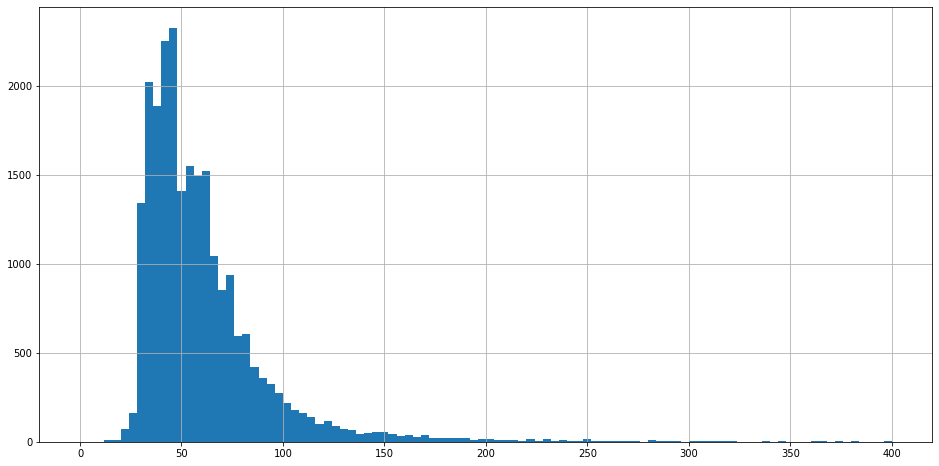

In [232]:
# построим гистограмму для общей площади
df['total_area'].hist(bins=100, range = (0, 400), figsize=(16,8))
plt.show()

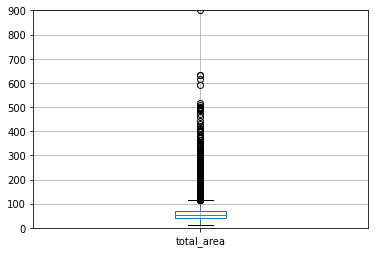

In [233]:
# построим диаграмму размаха для общей площади, чтобы увидеть выбросы (ящик с усами)

df.boxplot(column='total_area')
plt.ylim(0, 900)
plt.show()

In [234]:
# Оставим данные, где площадь меньше 400

df = df[df['total_area'] < 400]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23344 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23344 non-null  int64         
 1   last_price            23344 non-null  int64         
 2   total_area            23344 non-null  float64       
 3   first_day_exposition  23344 non-null  datetime64[ns]
 4   rooms                 23344 non-null  int64         
 5   ceiling_height        23344 non-null  float64       
 6   floors_total          23344 non-null  float64       
 7   living_area           23344 non-null  float64       
 8   floor                 23344 non-null  int64         
 9   is_apartment          23344 non-null  object        
 10  studio                23344 non-null  object        
 11  open_plan             23344 non-null  object        
 12  kitchen_area          23344 non-null  float64       
 13  balcony         

<AxesSubplot:>

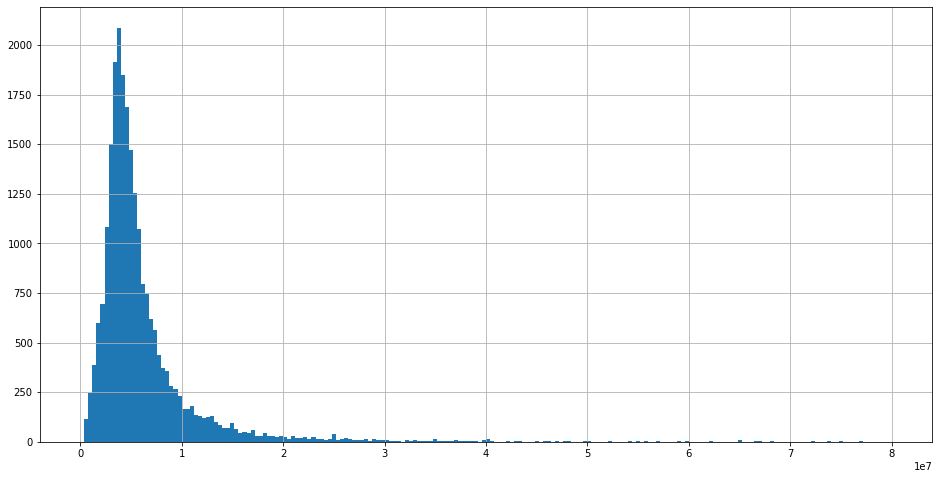

In [235]:
# построим гистограмму для стоимости квартир

df['last_price'].hist(bins=200, range = (0, 80000000), figsize=(16,8))

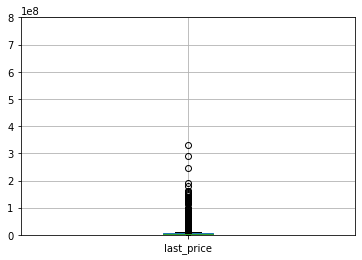

In [236]:
# диаграмма размаха для стоимости
df.boxplot(column='last_price')
plt.ylim(0, 800000000)
plt.show()

In [237]:
# Оставим данные, где стоимость квартиры меньше 22000 000

df = df[df['last_price'] < 22000000]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22753 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22753 non-null  int64         
 1   last_price            22753 non-null  int64         
 2   total_area            22753 non-null  float64       
 3   first_day_exposition  22753 non-null  datetime64[ns]
 4   rooms                 22753 non-null  int64         
 5   ceiling_height        22753 non-null  float64       
 6   floors_total          22753 non-null  float64       
 7   living_area           22753 non-null  float64       
 8   floor                 22753 non-null  int64         
 9   is_apartment          22753 non-null  object        
 10  studio                22753 non-null  object        
 11  open_plan             22753 non-null  object        
 12  kitchen_area          22753 non-null  float64       
 13  balcony         

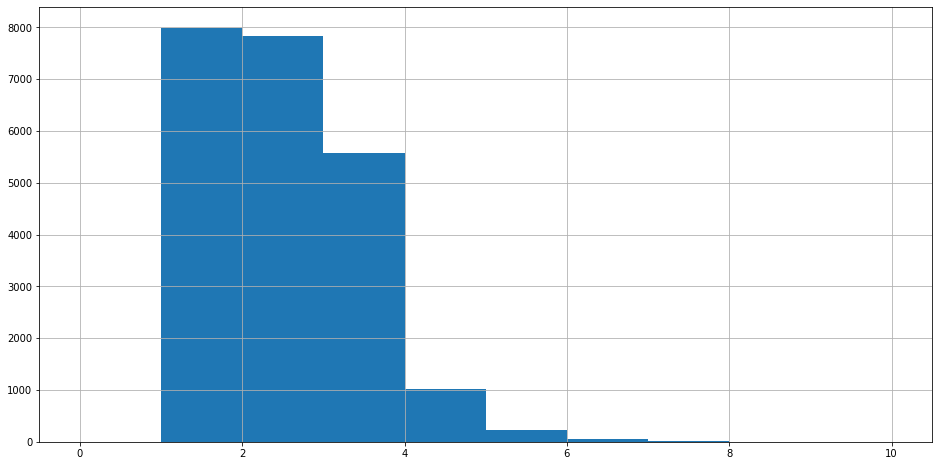

In [238]:
df['rooms'].hist(bins=10, range = (0, 10), figsize=(16,8))
plt.show()

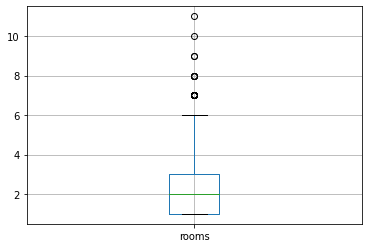

In [239]:
# ящик с усами для количества комнат
df.boxplot(column='rooms')
plt.show()

<AxesSubplot:>

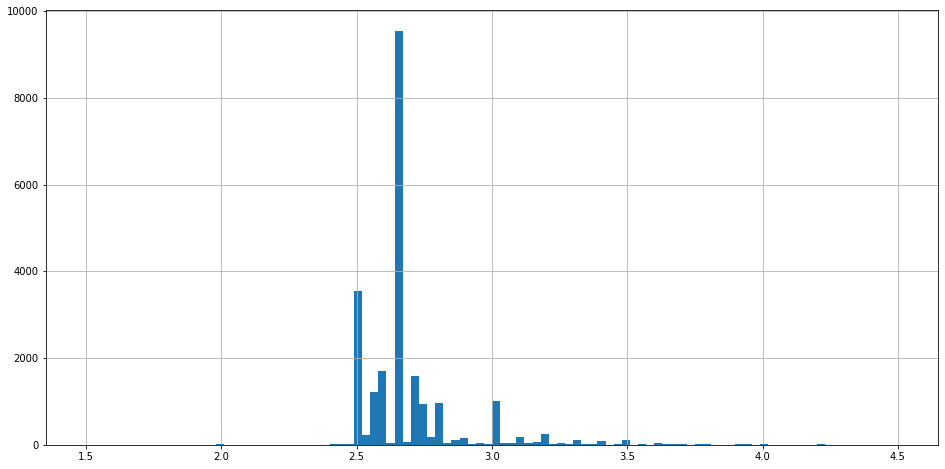

In [240]:
# строим гистограмму для высоты потолков

df['ceiling_height'].hist(bins=100, range=(1.5, 4.5), figsize=(16,8))

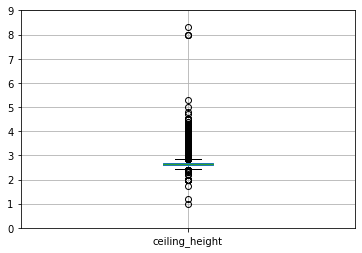

In [241]:
# диаграмма размаха для высоты потолков

df.boxplot(column='ceiling_height')
plt.ylim(0,9)
plt.show()


In [242]:
# оставим объявления с продажей квартир высотой потолков в промежутке с 2.5 до 4м
df = df[df['ceiling_height'] > 2.5]
df = df[df['ceiling_height'] <= 4]

# итоговый датафрейм после очистки
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19117 entries, 0 to 23697
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          19117 non-null  int64         
 1   last_price            19117 non-null  int64         
 2   total_area            19117 non-null  float64       
 3   first_day_exposition  19117 non-null  datetime64[ns]
 4   rooms                 19117 non-null  int64         
 5   ceiling_height        19117 non-null  float64       
 6   floors_total          19117 non-null  float64       
 7   living_area           19117 non-null  float64       
 8   floor                 19117 non-null  int64         
 9   is_apartment          19117 non-null  object        
 10  studio                19117 non-null  object        
 11  open_plan             19117 non-null  object        
 12  kitchen_area          19117 non-null  float64       
 13  balcony         

Изучим время продажи квартир


<AxesSubplot:>

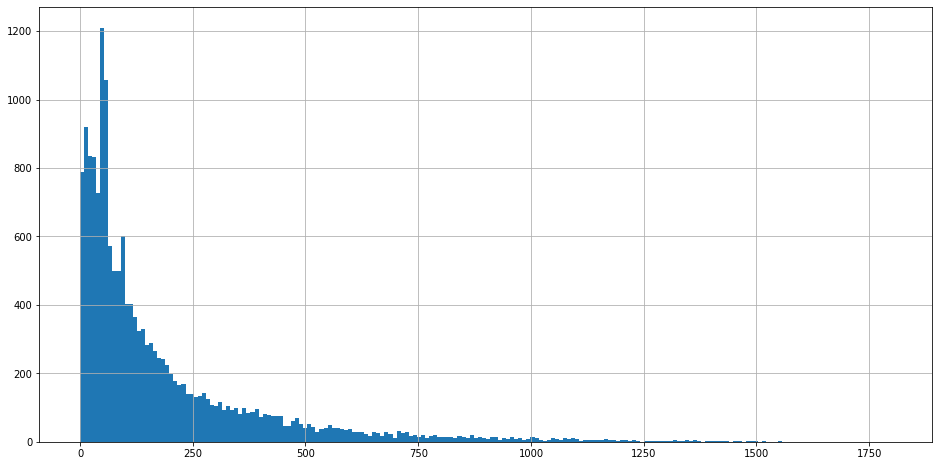

In [243]:
df['days_exposition'].hist(bins=200, range=(0, 1800), figsize=(16,8))

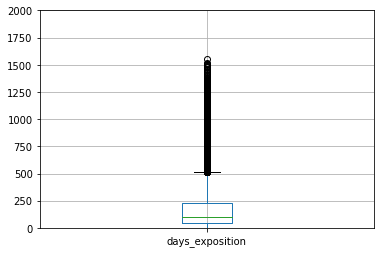

In [244]:
# диаграмма размаха для количества дней размещения

df.boxplot(column='days_exposition')
plt.ylim(0,2000)
plt.show()

In [245]:
df = df[df['days_exposition'] < 600]

# итоговый датафрейм после очистки
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15789 entries, 1 to 23695
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          15789 non-null  int64         
 1   last_price            15789 non-null  int64         
 2   total_area            15789 non-null  float64       
 3   first_day_exposition  15789 non-null  datetime64[ns]
 4   rooms                 15789 non-null  int64         
 5   ceiling_height        15789 non-null  float64       
 6   floors_total          15789 non-null  float64       
 7   living_area           15789 non-null  float64       
 8   floor                 15789 non-null  int64         
 9   is_apartment          15789 non-null  object        
 10  studio                15789 non-null  object        
 11  open_plan             15789 non-null  object        
 12  kitchen_area          15789 non-null  float64       
 13  balcony         

In [246]:
df['days_exposition'].describe() 


count   15789.00
mean      139.16
std       136.32
min         2.00
25%        43.00
50%        89.00
75%       195.00
max       599.00
Name: days_exposition, dtype: float64

<p>Здесь мы видим после очистки данных:</p>

<pre>
Среднее время продажи квартиры mean       139 дней
Медиана         89 дней </pre>

<p>Значит верным будет предположение, что в среднем квартиры продаются за 3-4 мес. с начала публикации. Также есть достаточное количество "долгих" продаж от 1,5 лет, возможно это связано с рядом особенностей квартиры или завышенной стоимости. Самая быстрая продажа состоялась за 2 дня, также немало квартир удачно и быстро продались за месяц и менее, что можно заметить по графику.</p>

<p><em>Какие факторы больше всего влияют на стоимость квартиры?</em></p>

<p><em>Изучим зависимость&nbsp;цены&nbsp;от:</em></p>

<ol>
	<li><em>квадратного метра,</em></li>
	<li><em>числа комнат,</em></li>
	<li><em>этажа (первого или последнего),</em></li>
	<li><em>удалённости от центра.</em></li>
	<li><em>от даты размещения: дня недели, месяца и года.</em></li>


In [247]:
# Сначала посчитаем для всех параметров корелляцию, начнем со стоимости по отношению к общей площади

df['last_price'].corr(df['total_area'])

0.7741752809663789

Здесь значение близко к 1 по корреляции Пирсона означает высокую зависимость цены от размеров площади, что логично.

In [248]:
# По количеству комнат немного меньше

df['last_price'].corr(df['rooms'])

0.5328141818044058

In [249]:
# Так как в столбце расстояния до центра есть пропуски, то при проверке корреляции их нужно исключить,  метод notnull

df['last_price'].corr(df['citycenters_nearest'].notnull())

0.3983916413323352

<AxesSubplot:xlabel='floor_category'>

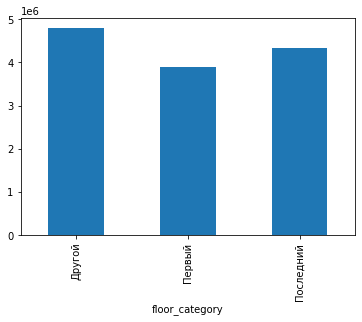

In [250]:
# Проверим зависимость от этажа

(df.groupby('floor_category')['last_price'].median()
    .plot(x='floor_category',y='last_price',kind='bar')
)

Квартиры на первом этаже обычно продаются дешевле остальных.

<AxesSubplot:xlabel='citycenters_nearest'>

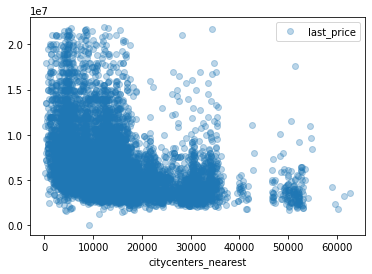

In [251]:
# Проверим зависимость на удаленность от центра

(df.sort_values(by='citycenters_nearest',ascending=True)
 .plot(x='citycenters_nearest',y='last_price',style='o',alpha=0.3)
)

Как следовало и ожидать, квартиры ближе к центру стоят дороже.

<AxesSubplot:xlabel='weekday'>

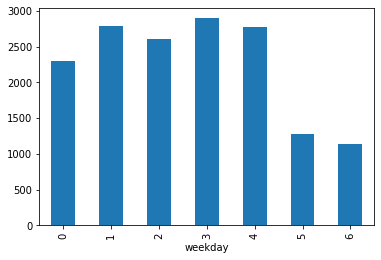

In [252]:
(df.groupby('weekday')['last_price'].count()
     .plot(x='weekday',y='last_price',kind='bar')
)

Меньше всего публикаций в выходные дни.


<AxesSubplot:xlabel='month'>

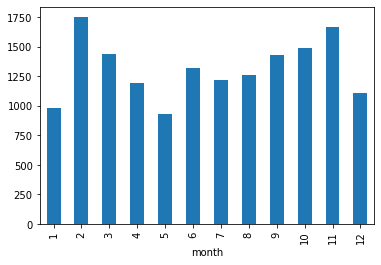

In [253]:
(df.groupby('month')['last_price'].count()
     .plot(x='month',y='last_price',kind='bar')
)

Здесь мы видим, что самые "непопулярные месяцы" для публикаций это праздничные и предпраздничные, январь, май и декабрь.

<AxesSubplot:xlabel='year'>

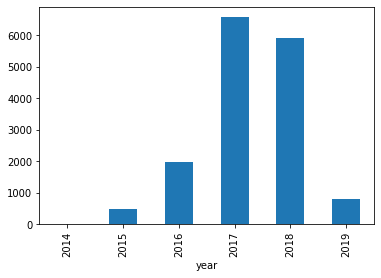

In [254]:
(df.groupby('year')['last_price'].count()
     .plot(x='year',y='last_price',kind='bar')
)

Значительно больше объявлений было в 2017 и 2018 годах, ранее 2016 скорее всего площадка для размещения только набирала популярность, поэтому их очень мало на тот момент.

<p><em>Выберем&nbsp;10 населённых пунктов с наибольшим числом объявлений. Посчитаем среднюю цену квадратного метра в этих населённых пунктах. Выделим&nbsp;населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце&nbsp;<code>locality_name</code></em></span></p>




In [255]:
# Создадм новую таблицу для 10 населенных пунктов с наибольшим числом объявлений

df_10 = df.pivot_table(index='locality_name',values='m_price',aggfunc=('count','median'))
df_10.sort_values(by='count',ascending=False).head(10)

# df_10 = df.pivot_table(index=['locality_name'], values=['last_price'], aggfunc='count')
# df_10.columns = ['count']
# df_10 = df_10.sort_values(by='count', ascending=False).head(10)

# df_10

,count,median
locality_name,,
Санкт-Петербург,10514.00,103201.50
Мурино,493.00,84876.00
Кудрово,393.00,94507.00
поселок Шушары,364.00,75933.00
Всеволожск,288.00,65789.00
поселок Парголово,277.00,91516.00
Пушкин,217.00,99650.00
Колпино,209.00,74137.00
Гатчина,196.00,67721.50


Больше всего объявлений в Санкт-Петербурге, а вот по стоимости за квадратный метр от Петербурга почти не отстают - Пушкин и Кудрово, около 100 тыс. за кв.м. В Выборге самая низкая стоимость - 58 тыс. за кв.м и меньше всего предложений.

<p><em>Изучим&nbsp; квартиры в Санкт-Петербурге (`locality_name`).</em></p>

<p><em>Выясним, какая область входит в центр. Создадим столбец с расстоянием до центра в километрах. После этого посчитаем среднюю цену для каждого километра.</em></p>

<p><em>Сделаем график: он должен показывать, как цена зависит от удалённости от центра. Определим&nbsp;границу, где график сильно меняется &mdash; это и будет центральная зона.</em></p>



In [256]:
# Удалим строки с пропусками в столбце citycenters_nearest

df.dropna(subset = ['citycenters_nearest'], how='all', inplace=True)

# Создадим столбец с расстоянием до центра в километрах и столбец с ценой за км удаленности от центра
  
df['centre_distance'] = (df['citycenters_nearest'] / 1000).astype(int)
df['km_centre_price'] = (df['last_price']/df['centre_distance']).astype(float)

# Заменяем записи с inf и -inf на пропуски, а потом удаляем записи с пропусками по столбцу цены  за км
df['km_centre_price']  = df['km_centre_price'] .replace([np.inf, -np.inf], np.nan).dropna()

# Создадим отдельный датафрейм для Санкт-Петербурга

df_spb = df[df['locality_name'] == 'Санкт-Петербург']
df_spb.reset_index(inplace=True)

# Формат данных с округлением данных float до 2 знаков после запятой
pd.options.display.float_format = '{:.2f}'.format

df_spb



,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,days_exposition,m_price,weekday,month,year,floor_category,living_to_total,kitchen_to_total,centre_distance,km_centre_price
0,2,10,5196000,56.00,2015-08-20,2,2.65,5.00,34.30,4,...,558.00,92785,3,8,2015,Другой,0.61,0.15,13,399692.31
1,4,2,10000000,100.00,2018-06-19,2,3.03,14.00,32.00,13,...,121.00,100000,1,6,2018,Другой,0.32,0.41,8,1250000.00
2,10,5,5050000,39.60,2017-11-16,1,2.67,12.00,20.30,3,...,137.00,127525,3,11,2017,Другой,0.51,0.21,13,388461.54
3,15,16,4650000,39.00,2017-11-18,1,2.65,14.00,20.50,5,...,19.00,119230,5,11,2017,Другой,0.53,0.19,14,332142.86
4,16,11,6700000,82.00,2017-11-23,3,3.05,5.00,55.60,1,...,397.00,81707,3,11,2017,Первый,0.68,0.11,10,670000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10492,23687,6,3200000,39.00,2017-12-16,1,2.65,9.00,20.00,6,...,38.00,82051,5,12,2017,Другой,0.51,0.28,16,200000.00
10493,23688,19,9200000,101.00,2019-04-01,3,3.05,15.00,63.00,12,...,23.00,91089,0,4,2019,Другой,0.62,0.15,14,657142.86
10494,23689,13,3550000,35.30,2018-02-28,1,2.86,15.00,16.30,4,...,29.00,100566,2,2,2018,Другой,0.46,0.26,16,221875.00
10495,23690,3,5500000,52.00,2018-07-19,2,2.65,5.00,31.00,2,...,15.00,105769,3,7,2018,Другой,0.60,0.12,6,916666.67


In [257]:
df_spb['km_centre_price'].describe()

count      10447.00
mean      956043.88
std      1538884.52
min         1354.44
25%       318181.82
50%       459000.00
75%       908333.33
max     21000000.00
Name: km_centre_price, dtype: float64

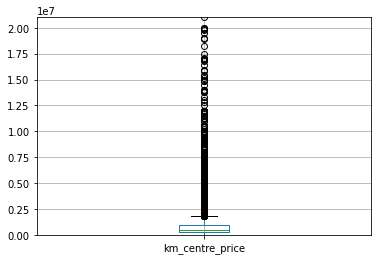

In [258]:
# диаграмма размаха для цены за км

df_spb.boxplot(column='km_centre_price')
plt.ylim(0,21000000)
plt.show()

In [259]:
# как мы заметили на прошлой диаграмме - очень много выбросов, поэтому срежем данные для точности, 
# оставим квартиры до 3 млн. руб. за кв м

df_spb = df_spb[df_spb['km_centre_price'] < 3000000]

<AxesSubplot:xlabel='centre_distance'>

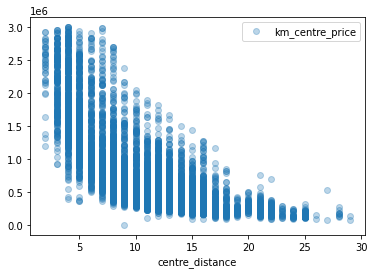

In [260]:
# посмотрим как распределяются теперь цены в зависимости от удаленности от центра

(df_spb.sort_values(by='centre_distance',ascending=True)
 .plot(x='centre_distance',y='km_centre_price',style='o',alpha=0.3)
)


Как видно по графику самая высокая цена за кв.м у квартир, которые находятся в удаленности до 3 км от центра Санкт-Петербурга, достигает 3 млн. руб., будем считать её "центральной зоной"("золотой треугольник" Петербурга).
В промежутке с 7 до 25 км от центра города цена практически не меняется, колеблется в раойне 500 тыс. руб за кв.м.


<p><em>Выделим&nbsp;сегмент квартир в центре.</em></p>

<p><em>Проанализируем&nbsp;эту территорию и изучим&nbsp;следующие параметры:</em></p>

<ul>
	<li><em>площадь,</em></li>
	<li><em>цена,</em></li>
	<li><em>число комнат,</em></li>
	<li><em>высота потолков.</em></li>
</ul>

In [261]:
# Оставим только те объявления, квартиры в которых находятся в радиусе 3 км от центра города

df_spb = df_spb[df_spb['centre_distance'] < 3]

# Получим список характерных значений для необходимых столбцов

data_df_spb = df_spb[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

In [262]:
data_df = df[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

In [263]:
# Объединим данные по таблицам, в добавленные справа столбцы от data_df_spb присоединим суффикс спб, чтобы видеть разницу

df_df = data_df_spb.join(data_df, rsuffix='_spb')

# Поменяем местами столбцы для удобства

df_df = pd.DataFrame(df_df, columns=['total_area', 'total_area_spb', 'last_price', 'last_price_spb', 'rooms', 'rooms_spb', 'ceiling_height', 'ceiling_height_spb'])
df_df

,total_area,total_area_spb,last_price,last_price_spb,rooms,rooms_spb,ceiling_height,ceiling_height_spb
count,38.00,12206.00,38.00,12206.00,38.00,12206.00,38.00,12206.00
mean,47.60,59.18,4772839.47,6199075.67,1.76,2.03,2.92,2.72
std,20.77,26.20,858785.49,3269858.72,0.97,0.99,0.35,0.19
min,20.00,12.00,2385000.00,12190.00,1.00,1.00,2.60,2.51
25%,38.00,41.00,4390000.00,4000000.00,1.00,1.00,2.65,2.65
50%,44.50,53.00,4974500.00,5200000.00,2.00,2.00,2.80,2.65
75%,55.38,70.80,5387500.00,7300000.00,2.00,3.00,3.08,2.71
max,151.80,320.00,5850000.00,21900000.00,6.00,10.00,4.00,4.00


<p><em><strong>Какие выводы можно сделать:</strong></em></p>

<p>&nbsp;</p>

<ul>
	<li>средняя площадь квартир в центре СПб немного меньше, чем площадь по общей таблице;</li>
	<li>что касается стоимости, то средняя стоимость квартир в центре СПб ниже, чем по всем данных в среднем. Скорее всего это связано как раз с тем, что по площади в центре СПб квартиры меньше, чем в другой области города и пригородах;</li>
	<li>по количеству комнат практически нет отличий, в основном это 2 комнатные, максимально 9 и 10 комнат, соответсвенно;</li>
	<li>высота потолков в центре СПб чуть ниже, чем по другим территориям. Хотя странно, ведь казалось, в центральной части много домов с потолками порядка 4 м.</li>
</ul>


## Общий вывод

<p><strong>Изучив данные из таблицы можно сделать следующие выводы:</strong></p>

<p><em>по стоимости:</em></p>

<ul>
	<li>стоимость квартир практически напрямую зависит от общей площади квартиры</li>
	<li>самые высокие цены за 1 кв м у квартир в Санкт-Петербурге, Кудрово и Пушкине - около 100 тыс. за кв.м.</li>
	<li>самые дорогие квартиры в Петербурге в радиусе удаления от центра города до 3 км</li>
	<li>квартиры на первых этажах обычно дешевле</li>
</ul>

<p><em>по особенностям:</em></p>

<ul>
	<li>реже всего люди публикуют объявления в выходные дни и праздничные и предпраздничные месяцы (январь, май, декабрь)</li>
	<li>значительно больше объявлений было в 2017 и 2018 годах, ранее 2016 скорее всего площадка для размещения только набирала популярность, поэтому их очень мало на тот момент</li>
	<li>если требуется квартира с большой площадью, то больше вариантов окажется за пределами &quot;центральной зоны&quot; Петербурга, т.к. при сравнении мы выяснили, что в среднем плоащадь в центре меньше, чем в остальных районах</li>
	<li>высота потолков в объявлениях в среднем не отличается от стандартной, хотя встречают и высокие потолки до 4 м как в центре города, так и по остальной области</li>
</ul>



<p><strong>ВЫВОД:</strong></p>

<p><span style="color:#000000"><strong>Чтобы автоматизировать получение рыночной стоимости, следует учитывать следующие параметры:</strong></span></p>

<ul>
	<li><span style="color:#006699">расположение квартиры на первом этаже - снижает стоимость, можно вычислить коэффициент соотношения&nbsp;</span></li>
	<li><span style="color:#006699">квартиры в радиусе удаленности от центра города до 10 км как правило на 40-50% дороже&nbsp;</span></li>
	<li><span style="color:#006699">общая площадь квартиры анпрямую влияет на стоимость жилья, положительная корреляция в пределах 0.77</span></li>
	<li><span style="color:#006699">количество комнат тоже прибавляет значение к стоимости</span></li>
	<li><span style="color:#006699">также следует обратить внимание, что в Санкт-Петербурге, Пушкине и в Кудрово стоимость квартир на 10-20% выше</span></li>
	<li><span style="color:#006699">по графику мы заметили что обычно квартиры продают в большинстве случаев в среднем за 3-4 мес.,такие записи лучше брать за ориентиры, т.к. в них скорее всего параметры квартиры и ее стоимость соответствуют действительности, а не завышены или занижены в целях мошенничества или для привлечения внимания, например</span></li>
</ul>


<p><strong>Рекомендации:</strong></p>

<ul>
	<li>чтобы исключить дубликаты данных:</li>
	<li>для самых популярных населенных пунктов сделать поле с возможностью выбора названия, если среди списка нет, тогда поле для ввода</li>
	<li>в поле is_apartment сделать булевый тип данных - и по умолчанию задать значение False, чтобы исключить большое количество пропусков</li>
	<li>добавить поля с указанием стоимости за кв метр</li>
</ul>
